# Prepare data for bicycle networks analysis
## Project: Bicycle network analysis with Gourab, Sayat, Tyler, Michael, Roberta

This notebook downloads bicycle and street network data sets and prepares them for analysis.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-09  
Last modified: 2020-06-25

## Preliminaries

### Imports and magics

In [1]:
import osmnx as ox
import networkx as nx
import watermark

import fiona
import shapely
from shapely.ops import cascaded_union

%load_ext watermark

In [2]:
%watermark -n -v -m -g -iv

fiona     1.8.13
networkx  2.4
osmnx     0.13.0
shapely   1.7.0
watermark 2.0.2
Thu Jun 25 2020 

CPython 3.8.2
IPython 7.14.0

compiler   : Clang 9.0.1 
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit
Git hash   :


### Parameters

In [5]:
datapath = "../data/"
#cities = {'copenhagen':"Copenhagen Municipality", 'paris':"Paris, France"} # dict of placeid:nominativstring
cities = {'copenhagen':"Copenhagen Municipality"}
osmnxparameters = {'car30':{'network_type':'drive', 'custom_filter':'["maxspeed"~"30"]'},
                   'carall':{'network_type':'drive', 'custom_filter':''}
                  }  
# special case 'biketrack': "cycleway"~"track" OR "highway"~"cycleway" OR "bicycle"~"designated" OR "cycleway:right=track" OR "cycleway:left=track"
# special case 'bikeable': biketrack OR car30
# See: https://wiki.openstreetmap.org/wiki/Key:cycleway#Cycle_tracks

# For now we get all the railway stations (including metro), and bus stops
poiparameters = {"railwaystation":{'railway':['station','halt']},
                 "busstop":{'highway':'bus_stop'}
                }

plotnetworks = True
maptiles = ('cartodbpositron','openstreetmap')
edge_colors = ('#0033cc',)

To get shapefiles:
* Go to [Overpass](overpass-turbo.eu), to the city, and run:
    `relation["boundary"="administrative"]["name:en"="Copenhagen Municipality"]({{bbox}});(._;>;);out skel;`
* Export: Download as GPX
* Use QGIS to create a polygon, with Vector > Join Multiple Lines, and Processing Toolbox > Polygonize (see https://gis.stackexchange.com/questions/98320/connecting-two-line-ends-in-qgis-without-resorting-to-other-software and https://gis.stackexchange.com/questions/207463/convert-a-line-to-polygon)

## Download and wrangle data

### Networks

In [89]:
for placeid, nominativstring in cities.items():
    #location = ox.gdf_from_place(nominativstring)
    # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
    shp = fiona.open(datapath+placeid+".shp")
    first = shp.next()
    location = shapely.geometry.shape(first['geometry'])
    # Cases in osmnxparameters
    for parameterid, parameterdict in osmnxparameters.items():
        G = ox.graph_from_polygon(location, 
                               network_type = parameterdict['network_type'],
                               custom_filter = (parameterdict['custom_filter']),
                               retain_all = True,
                               simplify = False)
        node,edge = ox.graph_to_gdfs(G)
        node.to_csv(datapath+placeid+'_'+parameterid+'_nodes.csv',index=False)
        edge.to_csv(datapath+placeid+'_'+parameterid+'_edges.csv',index=False)
    
    # Special cases biketrack and bikeable
    G1 = ox.graph_from_polygon(location,
                               network_type = 'bike',
                               custom_filter = ('["cycleway"~"track"]'),
                               retain_all = True,
                               simplify = False)
    G2 = ox.graph_from_polygon(location, 
                               network_type = 'bike',
                               custom_filter = ('["highway"~"cycleway"]'),
                               retain_all = True,
                               simplify = False)
    G3 = ox.graph_from_polygon(location, 
                               network_type = 'bike',
                               custom_filter = ('["bicycle"~"designated"]'),
                               retain_all = True,
                               simplify = False)
    G4 = ox.graph_from_polygon(location, 
                               network_type = 'bike',
                               custom_filter = ('["cycleway:right"~"track"]'),
                               retain_all = True,
                               simplify = False)
    G5 = ox.graph_from_polygon(location, 
                               network_type = 'bike',
                               custom_filter = ('["cycleway:left"~"track"]'),
                               retain_all = True,
                               simplify = False)
    Gcar30 = ox.graph_from_polygon(location, 
                               network_type = osmnxparameters['car30']['network_type'],
                               custom_filter = (osmnxparameters['car30']['custom_filter']),
                               retain_all = True,
                               simplify = False)
    
    parameterid = 'biketrack'
    G = nx.compose(G5,nx.compose(G1,nx.compose(G2,nx.compose(G3,G4))))
    node,edge = ox.graph_to_gdfs(G)
    node.to_csv(datapath+placeid+'_'+parameterid+'_nodes.csv',index=False)
    edge.to_csv(datapath+placeid+'_'+parameterid+'_edges.csv',index=False)
    
    parameterid = 'bikeable'
    G = nx.compose(Gcar30,G)
    node,edge = ox.graph_to_gdfs(G)
    node.to_csv(datapath+placeid+'_'+parameterid+'_nodes.csv',index=False)
    edge.to_csv(datapath+placeid+'_'+parameterid+'_edges.csv',index=False)

<ipython-input-89-64d2eab5a5a6>:5: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  first = shp.next()


### POIs

<ipython-input-6-1eb5e230de59>:3: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  first = shp.next()


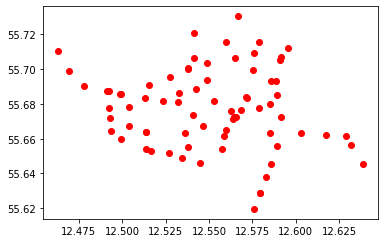

In [6]:
for placeid, nominativstring in cities.items():
    shp = fiona.open(datapath+placeid+".shp")
    first = shp.next()
    location = shapely.geometry.shape(first['geometry'])
    
    # We need the carall graph
    parameterdict = osmnxparameters['carall']
    G = ox.graph_from_polygon(location, 
                               network_type = parameterdict['network_type'],
                               custom_filter = (parameterdict['custom_filter']),
                               retain_all = True,
                               simplify = False)
    
    for poiid, poitag in poiparameters.items():
        gdf = ox.pois.pois_from_polygon(location, tags = poitag)
        gdf = gdf[gdf['geometry'].type == "Point"] # only consider points, no polygons etc
        # Now snap to closest nodes in street network, save the nearest node ids
        nnids = ox.distance.get_nearest_nodes(G, gdf['geometry'].x, gdf['geometry'].y)
        with open(datapath+placeid+'_'+'poi_'+poiid+'_nnidscarall.csv', 'w') as f:
            for item in nnids:
                f.write("%s\n" % item)
        
        gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
        gdf.to_file(datapath+placeid+'_'+'poi_'+poiid+'.gpkg', driver='GPKG')
        gdf.plot(color='red')

## Plot

In [90]:
parameterid

'bikeable'

In [ ]:
ox.folium.plot_graph_folium(G, graph_map=None, 
                                              popup_attribute=None, 
                                              tiles=maptiles[0], 
                                              zoom=19, 
                                              fit_bounds=True, 
                                              edge_color=edge_colors[0], 
                                              edge_width=2, 
                                              edge_opacity=.64)